In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
#!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/

In [3]:
#!pip3 install -U scikit-learn

In [4]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [5]:
#!pip install numpy

In [6]:
#!pip install mne

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_events_both(self):
        event_id = dict(T1=2, T2=3) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
        

    def create_epochs_both(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events_both()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    def get_X_y_both(self):
        if self.epochs is None:
            events , event_id=self.get_events_both()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        clear_output(wait=True)
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        clear_output(wait=True)
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

In [9]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(1,10)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()



Raw done
>>> Apply filter.
Filtering raw data in 27 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 405 events and 641 original time points ...
0 bad epochs dropped


(array([[   672,      0,      1],
        [  2000,      0,      0],
        [  3328,      0,      0],
        ...,
        [530960,      0,      0],
        [532272,      0,      1],
        [533584,      0,      0]]),
 {'T1': 0, 'T2': 1})

In [10]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)
X = X[:,:,:]
X.shape

(405, 64, 641) (405,)


(405, 64, 641)

In [11]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = '1.0.0'
path = 'physionet.org/files/eegmmidb/1.0.0'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [6, 10, 14]
subjects = [i for i in range(1,10)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs_both()



Raw done
>>> Apply filter.
Filtering raw data in 27 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 405 events and 641 original time points ...
0 bad epochs dropped


(array([[   672,      0,      3],
        [  2000,      0,      2],
        [  3328,      0,      2],
        ...,
        [530960,      0,      2],
        [532272,      0,      3],
        [533584,      0,      3]]),
 {'T1': 2, 'T2': 3})

In [12]:
X_b, y_b = eeg.get_X_y_both()

print(X_b.shape, y_b.shape)
X_b = X_b[:,:,:]
X_b.shape

(405, 64, 641) (405,)


(405, 64, 641)

In [13]:
X= np.concatenate((X,X_b))
y= np.concatenate((y,y_b))

#For game net
#X = X[:, np.newaxis,:,:]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(648, 64, 641) (648,)


In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [16]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(164096, 4)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [17]:
class gamenet(nn.Module):
    def __init__(self):
        
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(1,100,kernel_size=(1,25),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            nn.Conv2d(100,100,kernel_size=(7,1),stride=1,padding='valid'),
            #nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(18900),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(18900,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,4),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out

In [18]:
net = ConvNet().cuda(1)

In [19]:
# Loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=0.00000001)
criterion = nn.CrossEntropyLoss()

In [20]:
torch.cuda.device_count()

2

In [26]:
net.load_state_dict(torch.load('model_muti',map_location=torch.device('cuda:1')))


<All keys matched successfully>

In [ ]:
# Train the model
num_epochs = 100000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
old_train_loss = 10
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if train_loss[-1] < old_train_loss :
        torch.save(net.state_dict(), 'model_muti')
        old_train_loss = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 1/100000, Tr Loss: 1.4831, Tr Acc: 25.7716, Val Loss: 1.3867, Val Acc: 25.3086
Epoch 51/100000, Tr Loss: 1.4790, Tr Acc: 24.3827, Val Loss: 1.4219, Val Acc: 27.1605
Epoch 101/100000, Tr Loss: 1.4195, Tr Acc: 25.3086, Val Loss: 1.4073, Val Acc: 28.3951
Epoch 151/100000, Tr Loss: 1.4644, Tr Acc: 25.3086, Val Loss: 1.3807, Val Acc: 29.6296
Epoch 201/100000, Tr Loss: 1.4456, Tr Acc: 26.0802, Val Loss: 1.3730, Val Acc: 30.8642
Epoch 251/100000, Tr Loss: 1.4250, Tr Acc: 24.8457, Val Loss: 1.3487, Val Acc: 30.8642
Epoch 301/100000, Tr Loss: 1.4214, Tr Acc: 28.0864, Val Loss: 1.3661, Val Acc: 30.2469
Epoch 351/100000, Tr Loss: 1.4098, Tr Acc: 29.6296, Val Loss: 1.3952, Val Acc: 30.2469
Epoch 401/100000, Tr Loss: 1.3992, Tr Acc: 29.7840, Val Loss: 1.3911, Val Acc: 32.7160
Epoch 451/100000, Tr Loss: 1.4233, Tr Acc: 27.0062, Val Loss: 1.3917, Val Acc: 33.3333
Epoch 501/100000, Tr Loss: 1.4360, Tr Acc: 28.7037, Val Loss: 1.3884, Val Acc: 32.0988
Epoch 551/100000, Tr Loss: 1.4326, Tr Acc: 25.

In [ ]:
do_plot(train_accuracy, valid_accuracy,"acc")

In [ ]:
do_plot(train_loss, valid_loss,"loss")

In [ ]:
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


### validate


In [35]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = '1.0.0'
path = 'physionet.org/files/eegmmidb/1.0.0'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(11,12)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)

Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


(array([[  656,     0,     0],
        [ 1968,     0,     1],
        [ 3280,     0,     0],
        [ 4592,     0,     1],
        [ 5904,     0,     0],
        [ 7216,     0,     1],
        [ 8528,     0,     1],
        [ 9840,     0,     0],
        [11152,     0,     1],
        [12464,     0,     0],
        [13776,     0,     0],
        [15088,     0,     1],
        [16400,     0,     1],
        [17712,     0,     0],
        [19024,     0,     0],
        [20336,     0,     0],
        [21648,     0,     1],
        [22960,     0,     0],
        [24272,     0,     1],
        [25584,     0,     0],
        [26896,     0,     1],
        [28208,     0,     0],
        [29520,     0,     1],
        [30832,     0,     1],
        [32144,     0,     0],
        [33456,     0,     0],
        [34768,     0,     1],
        [36080,     0,     0],
        [37392,     0,     1],
        [38704,     0,     1],
        [40016,     0,     0],
        [41328,     0,     1],
        

In [36]:
X_val, y_val = eeg.get_X_y()

print(X.shape, y.shape)

X_val = X_val[:,:,:]
X_val.shape

(810, 64, 641) (810,)


(45, 64, 641)

In [37]:
test_loader = create_dataloader(X_val, y_val, batch_size=batch_size)

In [38]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 37.7778


### Freeze layer

In [84]:
for para in net.parameters():
    print(para)

Parameter containing:
tensor([[[ 4.1647e-02,  3.4528e-02, -5.7438e-02, -4.7233e-02,  2.3287e-02],
         [ 1.4989e-02, -5.6901e-03,  1.8233e-02, -2.4305e-02, -3.6511e-02],
         [-4.9470e-02,  3.7368e-02,  1.5992e-02, -5.2324e-02, -4.6464e-02],
         ...,
         [ 4.0320e-02, -1.3623e-02,  4.8849e-02,  5.8337e-03,  5.1701e-02],
         [-3.5901e-02, -2.9651e-02, -2.4911e-02, -1.4278e-02, -3.8129e-03],
         [ 1.6191e-02,  6.7435e-03, -2.5139e-02,  4.9338e-02, -5.5015e-02]],

        [[ 3.5161e-02,  1.7648e-02, -2.9901e-02,  3.2451e-02, -6.8587e-03],
         [ 2.4664e-02, -1.7039e-02, -2.3792e-02, -3.5417e-02,  3.6605e-02],
         [-3.9870e-02,  2.4531e-02,  3.1589e-02, -4.7702e-02,  3.1310e-02],
         ...,
         [-9.2841e-03, -3.8762e-02,  4.7822e-03,  5.0097e-02, -3.5561e-02],
         [ 3.4020e-02, -3.8841e-02, -4.3921e-02, -3.5000e-02,  3.0236e-02],
         [ 3.2494e-02,  7.3372e-03,  2.7424e-02,  6.4405e-03,  5.4075e-02]],

        [[ 2.8824e-02,  1.4765e-02

In [85]:
parms = net.state_dict()
parms.keys()

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [86]:
for name,param in net.named_parameters():
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = False
    if param.requires_grad and 'layer2' in name:
        param.requires_grad = False

In [87]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.1)

In [94]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = '1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [95]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:,:,:]
X.shape

(45, 64, 641) (45,)


(45, 64, 641)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(36, 64, 641) (36,)


In [97]:
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [98]:
# Train the model
num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if valid_accuracy[-1] > old_acc :
        torch.save(net.state_dict(), 'model_find_tune')
        old_acc = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 1/100, Tr Loss: 172.0203, Tr Acc: 41.6667, Val Loss: 239.8651, Val Acc: 66.6667
Epoch 51/100, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 6.8296, Val Acc: 88.8889
Epoch 100/100, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 6.7768, Val Acc: 88.8889


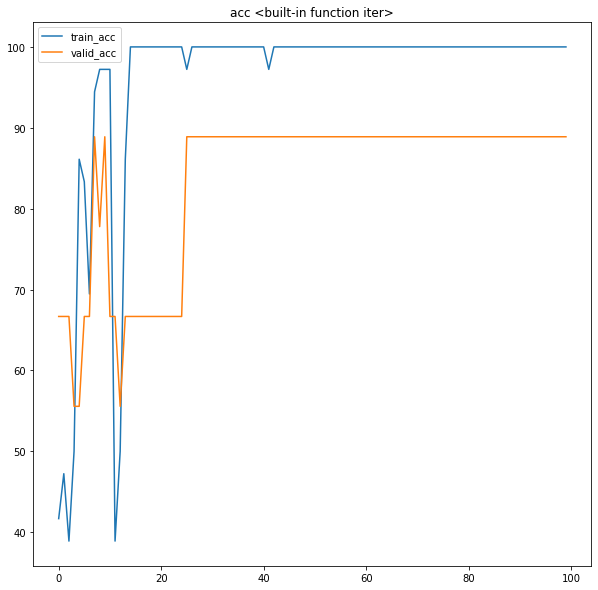

In [99]:
do_plot(train_accuracy, valid_accuracy,"acc")

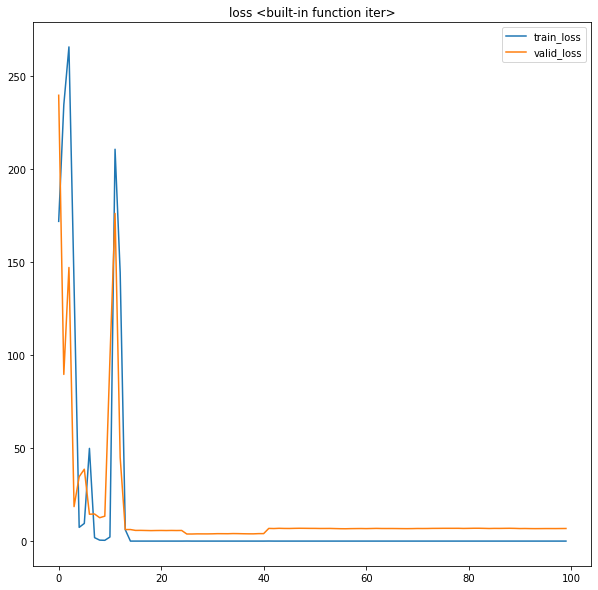

In [100]:
do_plot(train_loss, valid_loss,"loss")